In [1]:
from netpred.analysis import *
from sklearn.metrics import confusion_matrix
import seaborn as sns

# configure settings for all plots
plt.rcParams.update({'font.size': 12})

2022-04-10 12:56:48 Decompressing full_protein_dssp_annotations.json.gz
2022-04-10 12:56:49 Decompressing single_domain_dssp_annotations.json.gz
2022-04-10 12:56:56 Parsing casp11/validation...


NetPred(
  (prediction): PredictionNetwork(
    (stack): Sequential(
      (0): Linear(in_features=594, out_features=243, bias=True)
      (1): ReLU()
      (2): Linear(in_features=243, out_features=81, bias=True)
    )
  )
  (relu): ReLU()
  (filtering): FilteringNetwork(
    (stack): Sequential(
      (0): Linear(in_features=81, out_features=81, bias=True)
      (1): ReLU()
      (2): Linear(in_features=81, out_features=3, bias=True)
    )
  )
)


2022-04-10 12:56:56 Loaded 223 sequences from casp11/validation.
2022-04-10 12:56:56 Creating windows for casp11/validation ...
2022-04-10 12:56:57 Windowing complete for casp11/validation (created 48979 windows).


In [2]:
# distribution of states in test set
state_pmf = np.zeros(3)
for _, target in test_set:
    state_pmf[target] += 1

state_pmf /= np.sum(state_pmf)

print('distribution [H E C]', state_pmf * 100)
print('probability squared', np.sum(state_pmf * state_pmf) * 100)

distribution [H E C] [33.91045142 22.2728108  43.81673779]
probability squared 35.659033263149475


In [3]:
# accuracy over all residues
y_true, y_pred = [], []
for window, target in test_set:
    prediction = net(window.reshape(1, PSSM_ROWS * WINDOW_SIZE)).argmax().item()
    y_true.append(target)
    y_pred.append(prediction)

residue_accuracy = torch.count_nonzero(torch.tensor(y_pred) == torch.tensor(y_true)) / len(y_true)
print('Residue accuracy:', residue_accuracy.item() * 100)

Residue accuracy: 81.9126546382904


In [4]:
# accuracy over all proteins
protein_results = []
last = torch.ones(7)
for window, target in test_set:
    if window[-1, :WINDOW_CENTRE].sum().item() == WINDOW_CENTRE:  # if start of protein
        protein_results.append(torch.zeros(2))

    prediction = net(window.reshape(1, PSSM_ROWS * WINDOW_SIZE)).argmax().item()
    protein_results[-1] += torch.tensor([int(prediction == target), 1])

protein_results = torch.stack(protein_results)
protein_accuracies = protein_results[:, 0] / protein_results[:, 1]

std, mean = torch.std_mean(protein_accuracies)
print('mean accuracy:', mean.item() * 100)
print('std:', std.item())

mean accuracy: 81.97923302650452
std: 0.07412424683570862


Confusion matrix


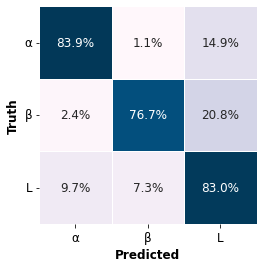

In [5]:
# confusion matrix
confusion = confusion_matrix(y_true, y_pred, normalize='true')

_, ax = plt.subplots(figsize=[4, 4])

p = sns.heatmap(confusion,
            cmap='PuBu',
            square=True,
            xticklabels=tick_labels,
            yticklabels=tick_labels,
            annot=True,
            fmt='.1%',
            cbar=False,
            linewidth=1,
            ax=ax)

p.set_xlabel('Predicted', weight='bold')
p.set_ylabel('Truth', weight='bold')
plt.yticks(rotation=0)
plt.savefig('confusion.pdf')
print('Confusion matrix')